<a href="https://colab.research.google.com/github/Haziq0210/Melaka-JobMarket-Analysis/blob/main/Job_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data & Libraries


In [ ]:
!pip install opendatasets
import opendatasets as od
import pandas as pd
od.download("https://www.kaggle.com/datasets/azraimohamad/jobstreet-all-job-dataset")
df = pd.read_csv("/content/jobstreet-all-job-dataset/jobstreet_all_job_dataset.csv")
df.head()

Skipping, found downloaded files in "./jobstreet-all-job-dataset" (use force=True to force download)


,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate
0,74630583.0,Procurement Executive (Contract),Coca-Cola Bottlers (Malaysia) Sdn Bhd,Position Purpose\nManage aspects of procuremen...,Negeri Sembilan,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",procurement-executive,Contract/Temp,NaN,2024-03-21T05:58:35Z
1,74660602.0,Account Executive/ Assistant,Acoustic & Lighting System Sdn Bhd,We are looking for a Account Executive/ Assist...,Petaling,Accounting,Bookkeeping & Small Practice Accounting,executive-assistant,Full time,"RM 2,800 – RM 3,200 per month",2024-03-22T06:52:57Z
2,74655679.0,"Data Analyst - Asset Management, SPX Express",Shopee Mobile Malaysia Sdn Bhd,Performs detailed data analysis on existing sp...,Klang District,"Manufacturing, Transport & Logistics",Analysis & Reporting,asset-management-analyst,Full time,NaN,2024-03-22T04:22:43Z
3,74657624.0,Service Engineer,Sun Medical Systems Sdn Bhd,"You are important for troubleshooting, install...",Petaling,Engineering,Electrical/Electronic Engineering,services-engineer,Full time,"RM 3,000 – RM 3,500 per month",2024-03-22T05:32:09Z
4,74679363.0,Purchasing Executive,Magnet Security & Automation Sdn. Bhd.,"MAG is a trailblazer in the industry, boasting...",Hulu Langat,"Manufacturing, Transport & Logistics","Purchasing, Procurement & Inventory",purchasing-executive,Full time,"RM 2,800 – RM 3,500 per month",2024-03-23T03:56:39Z


# Data Cleaning

In [ ]:
# Data Cleaning Function
import re
import numpy as np

def clean_salary(s,usd_to_rm=4.7, working_days_per_month=22,hours_per_day=8):

  # Replace symbols
  s = str(s).lower().replace(",", "").replace("–", "-").replace("—", "-").strip()

  # Non-numeric value
  if not any(char.isdigit() for char in s):
    return pd.Series([np.nan,np.nan,np.nan,"Unknown","Unknown"])

  #Currency
  if "$" in s:
    currency = "USD"
  elif "rm" in s or "myr" in s:
    currency = "RM"
  else:
    currency = "Unknown"

  if "year" in s or "per year" in s or "p.a." in s:
    period = "year"
  elif "hour" in s or "/hr" in s:
    period = "hour"
  else:
    period = "month"

  # Replace 'k'
  s = re.sub(r'(\d+)k', lambda m: str(int(m.group(1))*1000),s)

  # Extract the numeric value
  nums = re.findall(r"\d+\.?\d*",s)
  nums = [float(n) for n in nums]

  if not nums:
    return pd.Series([np.nan,np.nan,np.nan,currency,period])
  elif len(nums) == 1:
    min_salary = max_salary = avg_salary = nums[0]
  else:
    min_salary = nums[0]
    max_salary = nums[1]
    avg_salary = (min_salary + max_salary) / 2

  # Convert USD to RM
  if currency == "USD":
    min_salary *= usd_to_rm
    max_salary *= usd_to_rm
    avg_salary *= usd_to_rm

  # Convert yearly to monthly
  if period == "year":
    min_salary /= 12
    max_salary /= 12
    avg_salary /= 12

  # Convert hourly to monthly (we assume 22 working days per month, 8 hours per day)
  if period == "hour":
    min_salary *= working_days_per_month * hours_per_day
    max_salary *= working_days_per_month * hours_per_day
    avg_salary *= working_days_per_month * hours_per_day

  return pd.Series([min_salary,max_salary,avg_salary,currency,period])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69024 entries, 0 to 69023
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job_id        69024 non-null  float64
 1   job_title     69024 non-null  object 
 2   company       69024 non-null  object 
 3   descriptions  69024 non-null  object 
 4   location      69024 non-null  object 
 5   category      69024 non-null  object 
 6   subcategory   69024 non-null  object 
 7   role          66772 non-null  object 
 8   type          69024 non-null  object 
 9   salary        31594 non-null  object 
 10  listingDate   69024 non-null  object 
dtypes: float64(1), object(10)
memory usage: 5.8+ MB


In [ ]:
print(df.isna().sum())

job_id              0
job_title           0
company             0
descriptions        0
location            0
category            0
subcategory         0
role             2252
type                0
salary          37430
listingDate         0
dtype: int64


In [ ]:
clean_data = df.dropna(subset=["salary","role"])

In [ ]:
# Apply the clean salary function
clean_data[["min_salary", "max_salary", "avg_salary", "currency", "period"]] = clean_data["salary"].apply(clean_salary)

/tmp/ipython-input-441028906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data[["min_salary", "max_salary", "avg_salary", "currency", "period"]] = clean_data["salary"].apply(clean_salary)
/tmp/ipython-input-441028906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data[["min_salary", "max_salary", "avg_salary", "currency", "period"]] = clean_data["salary"].apply(clean_salary)
/tmp/ipython-input-441028906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
# Apply categorize function
low = 4850
medium = 10959
# Categorize salaries
def categorize_salary(avg):
  if pd.isna(avg):
    return 'Unknown'
  elif avg < low:
    return 'Low'
  elif avg < medium:
    return 'Medium'
  else:
    return 'High'
clean_data["salary_category"] = clean_data["avg_salary"].apply(categorize_salary)

/tmp/ipython-input-1087244234.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data["salary_category"] = clean_data["avg_salary"].apply(categorize_salary)


In [ ]:
print(clean_data.isna().sum())

job_id              0
job_title           0
company             0
descriptions        0
location            0
category            0
subcategory         0
role                0
type                0
salary              0
listingDate         0
min_salary         85
max_salary         85
avg_salary         85
currency            0
period              0
salary_category     0
dtype: int64


In [ ]:
# Extract indices of the NA row
indices = clean_data[clean_data['max_salary'].isna()].index
print(indices)

Index([ 1191,  1447,  2447,  4280,  4524,  5035,  5131,  6055,  6725,  7732,
        8013,  8067,  8432,  8740,  8895,  9399,  9533,  9970, 10608, 10824,
       11541, 16925, 17069, 17100, 17386, 17684, 17733, 17753, 17879, 18200,
       18941, 19224, 29973, 30041, 30098, 30211, 30427, 30428, 30849, 32810,
       33157, 33243, 33807, 34105, 35146, 35147, 35181, 35218, 35717, 35745,
       36708, 36710, 38649, 39434, 42152, 42693, 42762, 42982, 43084, 43197,
       43263, 43279, 43591, 44726, 45930, 46340, 52108, 52436, 53625, 59228,
       59507, 60385, 60818, 61256, 61273, 61444, 61947, 62695, 64283, 64645,
       65056, 65100, 65807, 66138, 68612],
      dtype='int64')


In [ ]:
# Data Cleaning (Drop NA for Salary column)
with_salary = clean_data.drop(indices)
print(with_salary.isna().sum())

job_id             0
job_title          0
company            0
descriptions       0
location           0
category           0
subcategory        0
role               0
type               0
salary             0
listingDate        0
min_salary         0
max_salary         0
avg_salary         0
currency           0
period             0
salary_category    0
dtype: int64


In [ ]:
# Data Cleaning (Location)
def locationClean(data):
  if "Larut" in data:
    return "Larut, Matang and Selama", "Perak"
  elif "Kuala Lumpur" in data:
    return "NA", "Kuala Lumpur"
  elif "Selangor" in data:
    return "NA", "Selangor"
  elif "Putrajaya" in data:
    return "NA","Wilayah Persekutuan Putrajaya"
  elif "Penang" in data:
    return "NA","Penang"
  elif "Johor" in data:
    return "NA","Johor"
  elif "Melaka" in data:
    return "NA","Melaka"
  elif "Sabah" in data:
    return "NA", "Sabah"
  elif "Perak" in data:
    return "NA", "Perak"
  elif "Sarawak" in data:
    return "NA","Sarawak"
  elif "Kedah" in data:
    return "NA","Kedah"
  elif "Kelantan" in data:
    return "NA","Kelantan"
  elif "Pahang" in data:
    return "NA","Pahang"
  elif "Negeri Sembilan" in data:
    return "NA","Negeri Sembilan"
  elif "Labuan" in data:
    return "NA","Labuan"
  elif "Terengganu" in data:
    return "NA","Terengganu"
  elif "Malaysia" in data:
    return "NA","Malaysia"
  elif "Others" in data:
    return "Others","Others"

  # Kuala Lumpur
  kl_district_list = ["Pudu","Alam Damai","Pandan Perdana","Wangsa Melawati","Taman Wahyu","Setiawangsa","Desa Parkcity","Kampung Pandan","Pantai Dalam","Lembah Keramat","Bukit Tunku","Taman United","Chow Kit","Bukit Kiara","Pusat Bandar Damansara","Desa ParkCity","Salak South","Taman Danau Desa","Taman Midah","Kampung Baru","Tun Razak Exchange","Happy Garden","Shamelin Perkasa","Bandar Sri Permaisuri","Desa ParkCity","Bandar Tasik Selatan","Bandar Menjalara","Taman OUG","Taman Connaught","Wangsa Maju","Maluri","Sri Hartamas","Brickfields","Desa ParkCity","Taman Desa","Segambut","Kampung Malaysia Raya","Sentul","Sungai Besi","Bangsar South","Bangsar","Kepong","KL Eco City","Mont Kiara","Bukit Jalil","Mid Valley City","Bandar Malaysia","Bukit Bintang","Kuchai Lama","Setapak","Taman Tun Dr Ismail","Jalan Ipoh","Bukit Damansara"]
  for kl_district in kl_district_list:
    if kl_district in data:
      return kl_district, "Kuala Lumpur"

  # Selangor
  selangor_district_list = ["Ampang","Sabak Bernam","Gombak Setia","Petaling","Shah Alam/Subang","Klang District","Hulu Langat","Kajang/Bangi/Serdang","Klang/Port Klang","Sepang","Cheras","Gombak District","Kuala Langat"]
  for selangor_district in selangor_district_list:
    if selangor_district in data:
      return selangor_district, "Selangor"

  # Johor
  johor_district_list = ["Segamat District","Mersing District","Kota Tinggi District","Tangkak District","Kluang District","Johor Bahru District","Kulai District","Batu Pahat District","Pontian","Muar District"]
  for johor_district in johor_district_list:
    if johor_district in data:
      return johor_district, "Johor"

  # Perak
  perak_district_list = ["Kinta District","Kerian District","Bagan Datuk District","Batang Padang District","Muallim District","Manjung District","Kampar District","Kuala Kangsar District"]
  for perak_district in perak_district_list:
    if perak_district in data:
      return perak_district, "Perak"

  # Negeri Sembilan
  N9_district_list = ["Seremban District","Port Dickson District","Tampin District","Jempol District","Rembau District","Kuala Pilah District"]
  for N9_district in N9_district_list:
    if N9_district in data:
      return N9_district, "Negeri Sembilan"

  # Sarawak
  sarawak_district_list = ["Kuching Division","Serian Division","Bintulu Division","Miri Division","Sibu Division","Mukah Division","Limbang Division","Sarikei Division"]
  for sarawak_district in sarawak_district_list:
    if sarawak_district in data:
      return sarawak_district, "Sarawak"

  # Sabah
  sabah_district_list = ["Penampang District","Semporna District","Ranau District","Sipitang District","Kudat District","Sandakan District","Kota Kinabalu District","Tawau District","Lahad Datu District"]
  for sabah_district in sabah_district_list:
    if sabah_district in data:
      return sabah_district, "Sabah"

  # Penang
  penang_district_list = ["Seberang Perai","Penang Island","Tanjung Bungah/Teluk Bahang"]
  for penang_district in penang_district_list:
    if penang_district in data:
      return penang_district, "Penang"

  # Kedah
  kedah_district_list = ["Kulim District","Sik District","Pendang District","Baling District","Kuala Muda","Kota Setar","Langkawi","Kubang Pasu"]
  for kedah_district in kedah_district_list:
    if kedah_district in data:
      return kedah_district, "Kedah"

  # Pahang
  pahang_district_list = ["Kuantan District","Lipis","Raub District","Maran District","Bentong District","Pekan District","Cameron Highlands","Temerloh District","Jerantut District"]
  for pahang_district in pahang_district_list:
    if pahang_district in data:
      return pahang_district, "Pahang"

  # Melaka
  melaka_district_list = ["Alor Gajah District","Jasin District"]
  for melaka_district in melaka_district_list:
    if melaka_district in data:
      return melaka_district, "Melaka"

  # Terengganu
  terengganu_district_list = ["Kuala Terengganu District","Kemaman","Setiu","Dungun","Besut","Marang District","Kuala Nerus District"]
  for terengganu_district in terengganu_district_list:
    if terengganu_district in data:
      return terengganu_district, "Terengganu"

  # Kelantan
  kelantan_district_list = ["Kota Bharu District","Gua Musang","Pasir Puteh","Pasir Mas District"]
  for kelantan_district in kelantan_district_list:
    if kelantan_district in data:
      return kelantan_district, "Kelantan"

  # Perlis
  perlis_district_list = ["Padang Besar"]
  for perlis_district in perlis_district_list:
    if perlis_district in data:
      return perlis_district, "Perlis"

  if "," in data:
    district, state = data.split(",",1)
    return district.strip(), state.strip()
  else:
    return "Unknown","Unknown"

with_salary[["Area","state"]] = with_salary["location"].apply(lambda x: pd.Series(locationClean(str(x))))
with_salary.head(2)

,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate,min_salary,max_salary,avg_salary,currency,period,salary_category,Area,state
1,74660602.0,Account Executive/ Assistant,Acoustic & Lighting System Sdn Bhd,We are looking for a Account Executive/ Assist...,Petaling,Accounting,Bookkeeping & Small Practice Accounting,executive-assistant,Full time,"RM 2,800 – RM 3,200 per month",2024-03-22T06:52:57Z,2800.0,3200.0,3000.0,RM,month,Low,Petaling,Selangor
3,74657624.0,Service Engineer,Sun Medical Systems Sdn Bhd,"You are important for troubleshooting, install...",Petaling,Engineering,Electrical/Electronic Engineering,services-engineer,Full time,"RM 3,000 – RM 3,500 per month",2024-03-22T05:32:09Z,3000.0,3500.0,3250.0,RM,month,Low,Petaling,Selangor


In [ ]:
# Check (How many location is not clean yet)
print("TOTAL LOCATION (Unknown): ",len(with_salary.loc[with_salary["Area"] == "Unknown", ["location"]].value_counts()))
print(with_salary.loc[with_salary["Area"] == "Unknown", ["location"]].value_counts().sort_values(ascending=False).head(30))

TOTAL LOCATION (Unknown):  0
Series([], Name: count, dtype: int64)


In [ ]:
# Type of Employement
Employement_Type = with_salary["type"].unique()
print(Employement_Type)

['Full time' 'Contract/Temp' 'Part time' 'Casual/Vacation' "['Full time']"
 "['Contract/Temp']" "['Part time']" "['Casual/Vacation']"]


In [ ]:
# Data Cleaning for "type"
with_salary["type_cleaned"] = (
    with_salary["type"]
    .astype(str)
    .str.replace(r"[\[\]']", "", regex=True)
    .str.strip()
)

In [ ]:
with_salary["type"] = with_salary["type_cleaned"]
with_salary.drop("type_cleaned",axis=1,inplace=True)

In [ ]:
with_salary["type"].unique()

array(['Full time', 'Contract/Temp', 'Part time', 'Casual/Vacation'],
      dtype=object)

# Exploratory Data Analysis (EDA)

In [ ]:
# Summary Statistics
print(with_salary["avg_salary"].describe().apply(lambda x:f"{x:,.2f}"))

count        30,732.00
mean          5,951.35
std          78,571.30
min               1.00
25%           3,000.00
50%           3,750.00
75%           5,150.00
max      11,167,200.00
Name: avg_salary, dtype: object


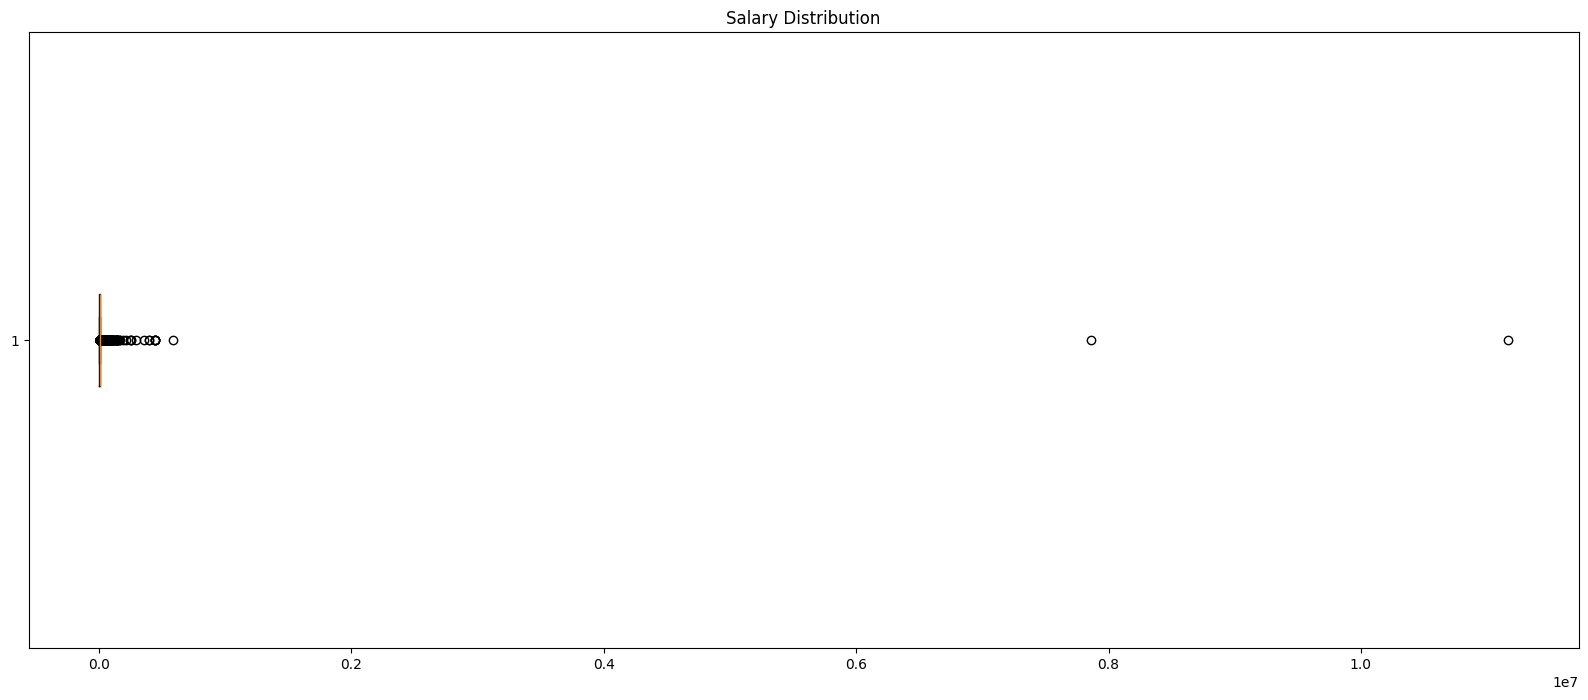

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.boxplot(with_salary["avg_salary"], vert=False)
plt.title("Salary Distribution")
plt.show()

In [ ]:
# Skewness
skewness = with_salary["avg_salary"].skew()
print(f"Skewness: {skewness}")

Skewness: 125.82981062429987


- The skewness is extremely high (positive skew - distribution has a long right tail)
- Most salaries are low and there is a few salaries is extremely high (outliers) where it pulling the mean way up higher
- We can't use mean as a indicator for salary because it pull up by the extreme values

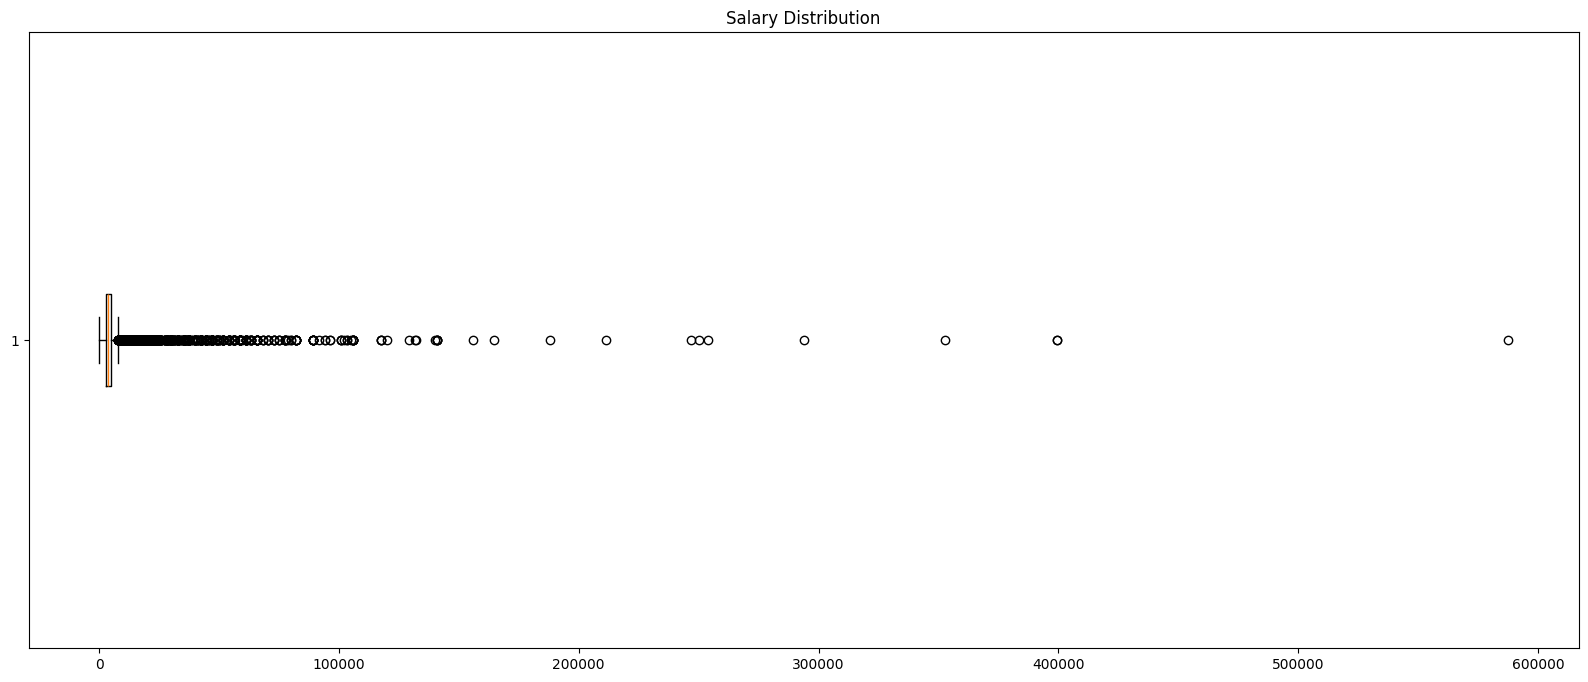

In [ ]:
# Excluding the year & hour payment method
monthly_salary = with_salary[~with_salary["period"].isin(["hour","year"])]

plt.figure(figsize=(20,8))
plt.boxplot(monthly_salary["avg_salary"], vert=False)
plt.title("Salary Distribution")
plt.show()

In [ ]:
skewness = monthly_salary["avg_salary"].skew()
print(f"Skewness: {skewness}")

Skewness: 24.946592526547015


- The outliers is keep in order to observe some naturally pay extremely high salaries such as CEOs position.
- To observe the extreme values in the salary and understand the salary gaps

# Salary Analysis (Overall)

In [ ]:
# Data Overview
monthly_salary.head(2)

,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate,min_salary,max_salary,avg_salary,currency,period,salary_category,Area,state
1,74660602.0,Account Executive/ Assistant,Acoustic & Lighting System Sdn Bhd,We are looking for a Account Executive/ Assist...,Petaling,Accounting,Bookkeeping & Small Practice Accounting,executive-assistant,Full time,"RM 2,800 – RM 3,200 per month",2024-03-22T06:52:57Z,2800.0,3200.0,3000.0,RM,month,Low,Petaling,Selangor
3,74657624.0,Service Engineer,Sun Medical Systems Sdn Bhd,"You are important for troubleshooting, install...",Petaling,Engineering,Electrical/Electronic Engineering,services-engineer,Full time,"RM 3,000 – RM 3,500 per month",2024-03-22T05:32:09Z,3000.0,3500.0,3250.0,RM,month,Low,Petaling,Selangor


In [ ]:
# Salary Distribution (Overall)
# Category
Salary_Category = monthly_salary.groupby("category")["avg_salary"].median().round(2).sort_values(ascending=False).reset_index()
Salary_Category.rename(columns={"avg_salary":"Median_Salary"},inplace=True)
Salary_Category.index = Salary_Category.index + 1
print(Salary_Category)

                                  category  Median_Salary
1                 CEO & General Management       11812.50
2   Information & Communication Technology        5400.00
3                    Consulting & Strategy        5000.00
4                   Real Estate & Property        4625.00
5         Community Services & Development        4500.00
6                             Construction        4500.00
7                                    Sales        4300.00
8             Banking & Financial Services        4250.00
9            Human Resources & Recruitment        4231.25
10                                   Legal        4000.00
11                             Engineering        4000.00
12                   Design & Architecture        4000.00
13              Mining, Resources & Energy        3775.00
14               Advertising, Arts & Media        3750.00
15                      Sport & Recreation        3750.00
16              Retail & Consumer Products        3750.00
17            

In [ ]:
# State
filtered = monthly_salary[~monthly_salary["state"].isin(["Malaysia","Others"])]
Salary_State = filtered.groupby("state")["avg_salary"].median().round(2).sort_values(ascending=False).reset_index()
Salary_State.rename(columns={"avg_salary":"Median_Salary"},inplace=True)
Salary_State.index = Salary_State.index + 1
print(Salary_State)

                            state  Median_Salary
1                    Kuala Lumpur         4250.0
2   Wilayah Persekutuan Putrajaya         3875.0
3                          Labuan         3750.0
4                           Johor         3750.0
5                          Penang         3750.0
6                        Selangor         3750.0
7                          Pahang         3500.0
8                           Kedah         3500.0
9                      Terengganu         3500.0
10                         Perlis         3500.0
11                Negeri Sembilan         3333.5
12                          Perak         3125.0
13                         Melaka         3100.0
14                          Sabah         3000.0
15                        Sarawak         3000.0
16                       Kelantan         2700.0


In [ ]:
# Role
Salary_Role = monthly_salary.groupby("role")["avg_salary"].median().round(2).sort_values(ascending=False).reset_index()
Salary_Role.rename(columns={"avg_salary":"Median_Salary"},inplace=True)
Salary_Role.index = Salary_Role.index + 1
print(Salary_Role.head(30))

                                          role  Median_Salary
1            information-technology-consultant       246750.0
2                            Precision-Manager       141000.0
3                           lending-specialist       140000.0
4                 premier-relationship-manager       120000.0
5                    enterprise-data-architect       105750.0
6                                  head-of-tax       103400.0
7                       Group-Taxation-Manager       103400.0
8      Head-of-Financial-Planning-and-Analysis       101050.0
9         Business-Development-General-Manager        96350.0
10               salesforce-solution-architect        89300.0
11                        enterprise-architect        89300.0
12                           insurance-manager        89300.0
13                 information-technology-lead        82875.0
14                  technical-delivery-manager        82250.0
15                      communications-manager        77550.0
16      

In [ ]:
# Type of Employement
Salary_Type = monthly_salary.groupby("type")["avg_salary"].median().round(2).sort_values(ascending=False).reset_index()
Salary_Type.rename(columns={"avg_salary":"Median_Salary"},inplace=True)
Salary_Type.index = Salary_Type.index + 1
print(Salary_Type)

              type  Median_Salary
1        Full time        3850.00
2    Contract/Temp        3000.00
3        Part time        2500.00
4  Casual/Vacation         974.75


# Job & Salary Analysis (Melaka)

In [ ]:
# Top 5
filtered = monthly_salary[~monthly_salary["state"].isin(["Malaysia","Others"])]
Job_Counts = filtered["state"].value_counts().sort_values(ascending=False).reset_index()
Job_Counts.index = Job_Counts.index + 1
print(Job_Counts)

                            state  count
1                        Selangor  11586
2                    Kuala Lumpur   8840
3                           Johor   3866
4                          Penang   2460
5                         Sarawak    679
6                           Perak    565
7                           Sabah    549
8                          Melaka    476
9                 Negeri Sembilan    457
10                          Kedah    387
11                         Pahang    241
12                       Kelantan     87
13                     Terengganu     81
14  Wilayah Persekutuan Putrajaya     58
15                         Labuan     21
16                         Perlis      3


- Melaka rank in number 8 out of 16 state with 476 Jobs Vacancies

In [ ]:
# Melaka Dataset
Melaka = monthly_salary[monthly_salary["state"] == "Melaka"]
Melaka.head(2)

,job_id,job_title,company,descriptions,location,category,subcategory,role,type,salary,listingDate,min_salary,max_salary,avg_salary,currency,period,salary_category,Area,state,month
105,74665214.0,Admin Assistant/ Admin Clerk,USJAYA SDN. BHD.,Job scope:\n-Key in Data/ Record data/\n-Filin...,Melaka,Administration & Office Support,Administrative Assistants,administration-officer,Full time,"RM 1,550 – RM 2,300 per month",2024-03-22 09:34:23+00:00,1550.0,2300.0,1925.0,RM,month,Low,NA,Melaka,2024-03
166,74636293.0,Admin Assistant,LIP KONG MANUFACTURING & MARKETING SDN. BHD.,REQUIREMENT:\nAGE: 21 – 35 YEARS OLD\nSPM ABOV...,Melaka,Administration & Office Support,Administrative Assistants,administration-officer,Full time,"RM 1,700 – RM 2,300 per month",2024-03-21 09:08:54+00:00,1700.0,2300.0,2000.0,RM,month,Low,NA,Melaka,2024-03


In [ ]:
# Median , Minimum, Maximum Salary in Melaka
Median_Salary_Melaka = Melaka["avg_salary"].median()
print(f"Median Salary in Melaka: RM{Median_Salary_Melaka}")


Median Salary in Melaka: RM3100.0


In [ ]:
# Total Job Vacancies Based on category (Melaka)
Total_Vacancies = Melaka["category"].value_counts().sort_values(ascending=False).reset_index()
Total_Vacancies.index = Total_Vacancies.index + 1
print(Total_Vacancies)

                                  category  count
1                               Accounting     97
2     Manufacturing, Transport & Logistics     60
3          Administration & Office Support     57
4                              Engineering     48
5                                    Sales     36
6               Marketing & Communications     27
7                     Healthcare & Medical     22
8            Human Resources & Recruitment     20
9                             Construction     17
10  Information & Communication Technology     16
11                   Hospitality & Tourism     14
12              Retail & Consumer Products     13
13                  Real Estate & Property     10
14            Banking & Financial Services      9
15                       Trades & Services      7
16                   Design & Architecture      6
17                    Education & Training      5
18          Call Centre & Customer Service      4
19               Advertising, Arts & Media      2


In [ ]:
# Salary Based on Category (Melaka)
Melaka_category = Melaka.groupby("category")["avg_salary"].median().round(2).sort_values(ascending=False).reset_index()
Melaka_category.rename(columns={"avg_salary":"Median_Salary"},inplace=True)
Melaka_category.index = Melaka_category.index + 1
print(Melaka_category)

                                  category  Median_Salary
1               Mining, Resources & Energy        7500.00
2         Community Services & Development        4250.00
3                             Construction        4250.00
4               Retail & Consumer Products        4250.00
5                              Engineering        4125.00
6   Information & Communication Technology        3750.00
7             Banking & Financial Services        3750.00
8                                    Sales        3750.00
9                   Real Estate & Property        3625.00
10                    Healthcare & Medical        3225.00
11           Human Resources & Recruitment        3200.00
12    Manufacturing, Transport & Logistics        3112.50
13                   Hospitality & Tourism        3050.00
14              Marketing & Communications        3000.00
15                              Accounting        3000.00
16                    Science & Technology        3000.00
17            

In [ ]:
# Merge the Job Count & Median Salary
jobcount_category = Total_Vacancies['category']
jobcount_count = Total_Vacancies['count']
salary_category = Melaka_category['category']
salary_median = Melaka_category['Median_Salary']

job_count_data = {
    'category': jobcount_category,
    'count': jobcount_count
}

median_salary_data = {
    'category': salary_category,
    'Median_Salary': salary_median
}

df_count = pd.DataFrame(job_count_data)
df_salary = pd.DataFrame(median_salary_data)
data_merge = pd.merge(df_count, df_salary, on='category')
data_merge.sort_values("Median_Salary", ascending=False, inplace=True)
data_merge.reset_index(drop=True, inplace=True)
print(data_merge)

                                  category  count  Median_Salary
0               Mining, Resources & Energy      1        7500.00
1               Retail & Consumer Products     13        4250.00
2         Community Services & Development      1        4250.00
3                             Construction     17        4250.00
4                              Engineering     48        4125.00
5   Information & Communication Technology     16        3750.00
6                                    Sales     36        3750.00
7             Banking & Financial Services      9        3750.00
8                   Real Estate & Property     10        3625.00
9                     Healthcare & Medical     22        3225.00
10           Human Resources & Recruitment     20        3200.00
11    Manufacturing, Transport & Logistics     60        3112.50
12                   Hospitality & Tourism     14        3050.00
13                              Accounting     97        3000.00
14              Marketing

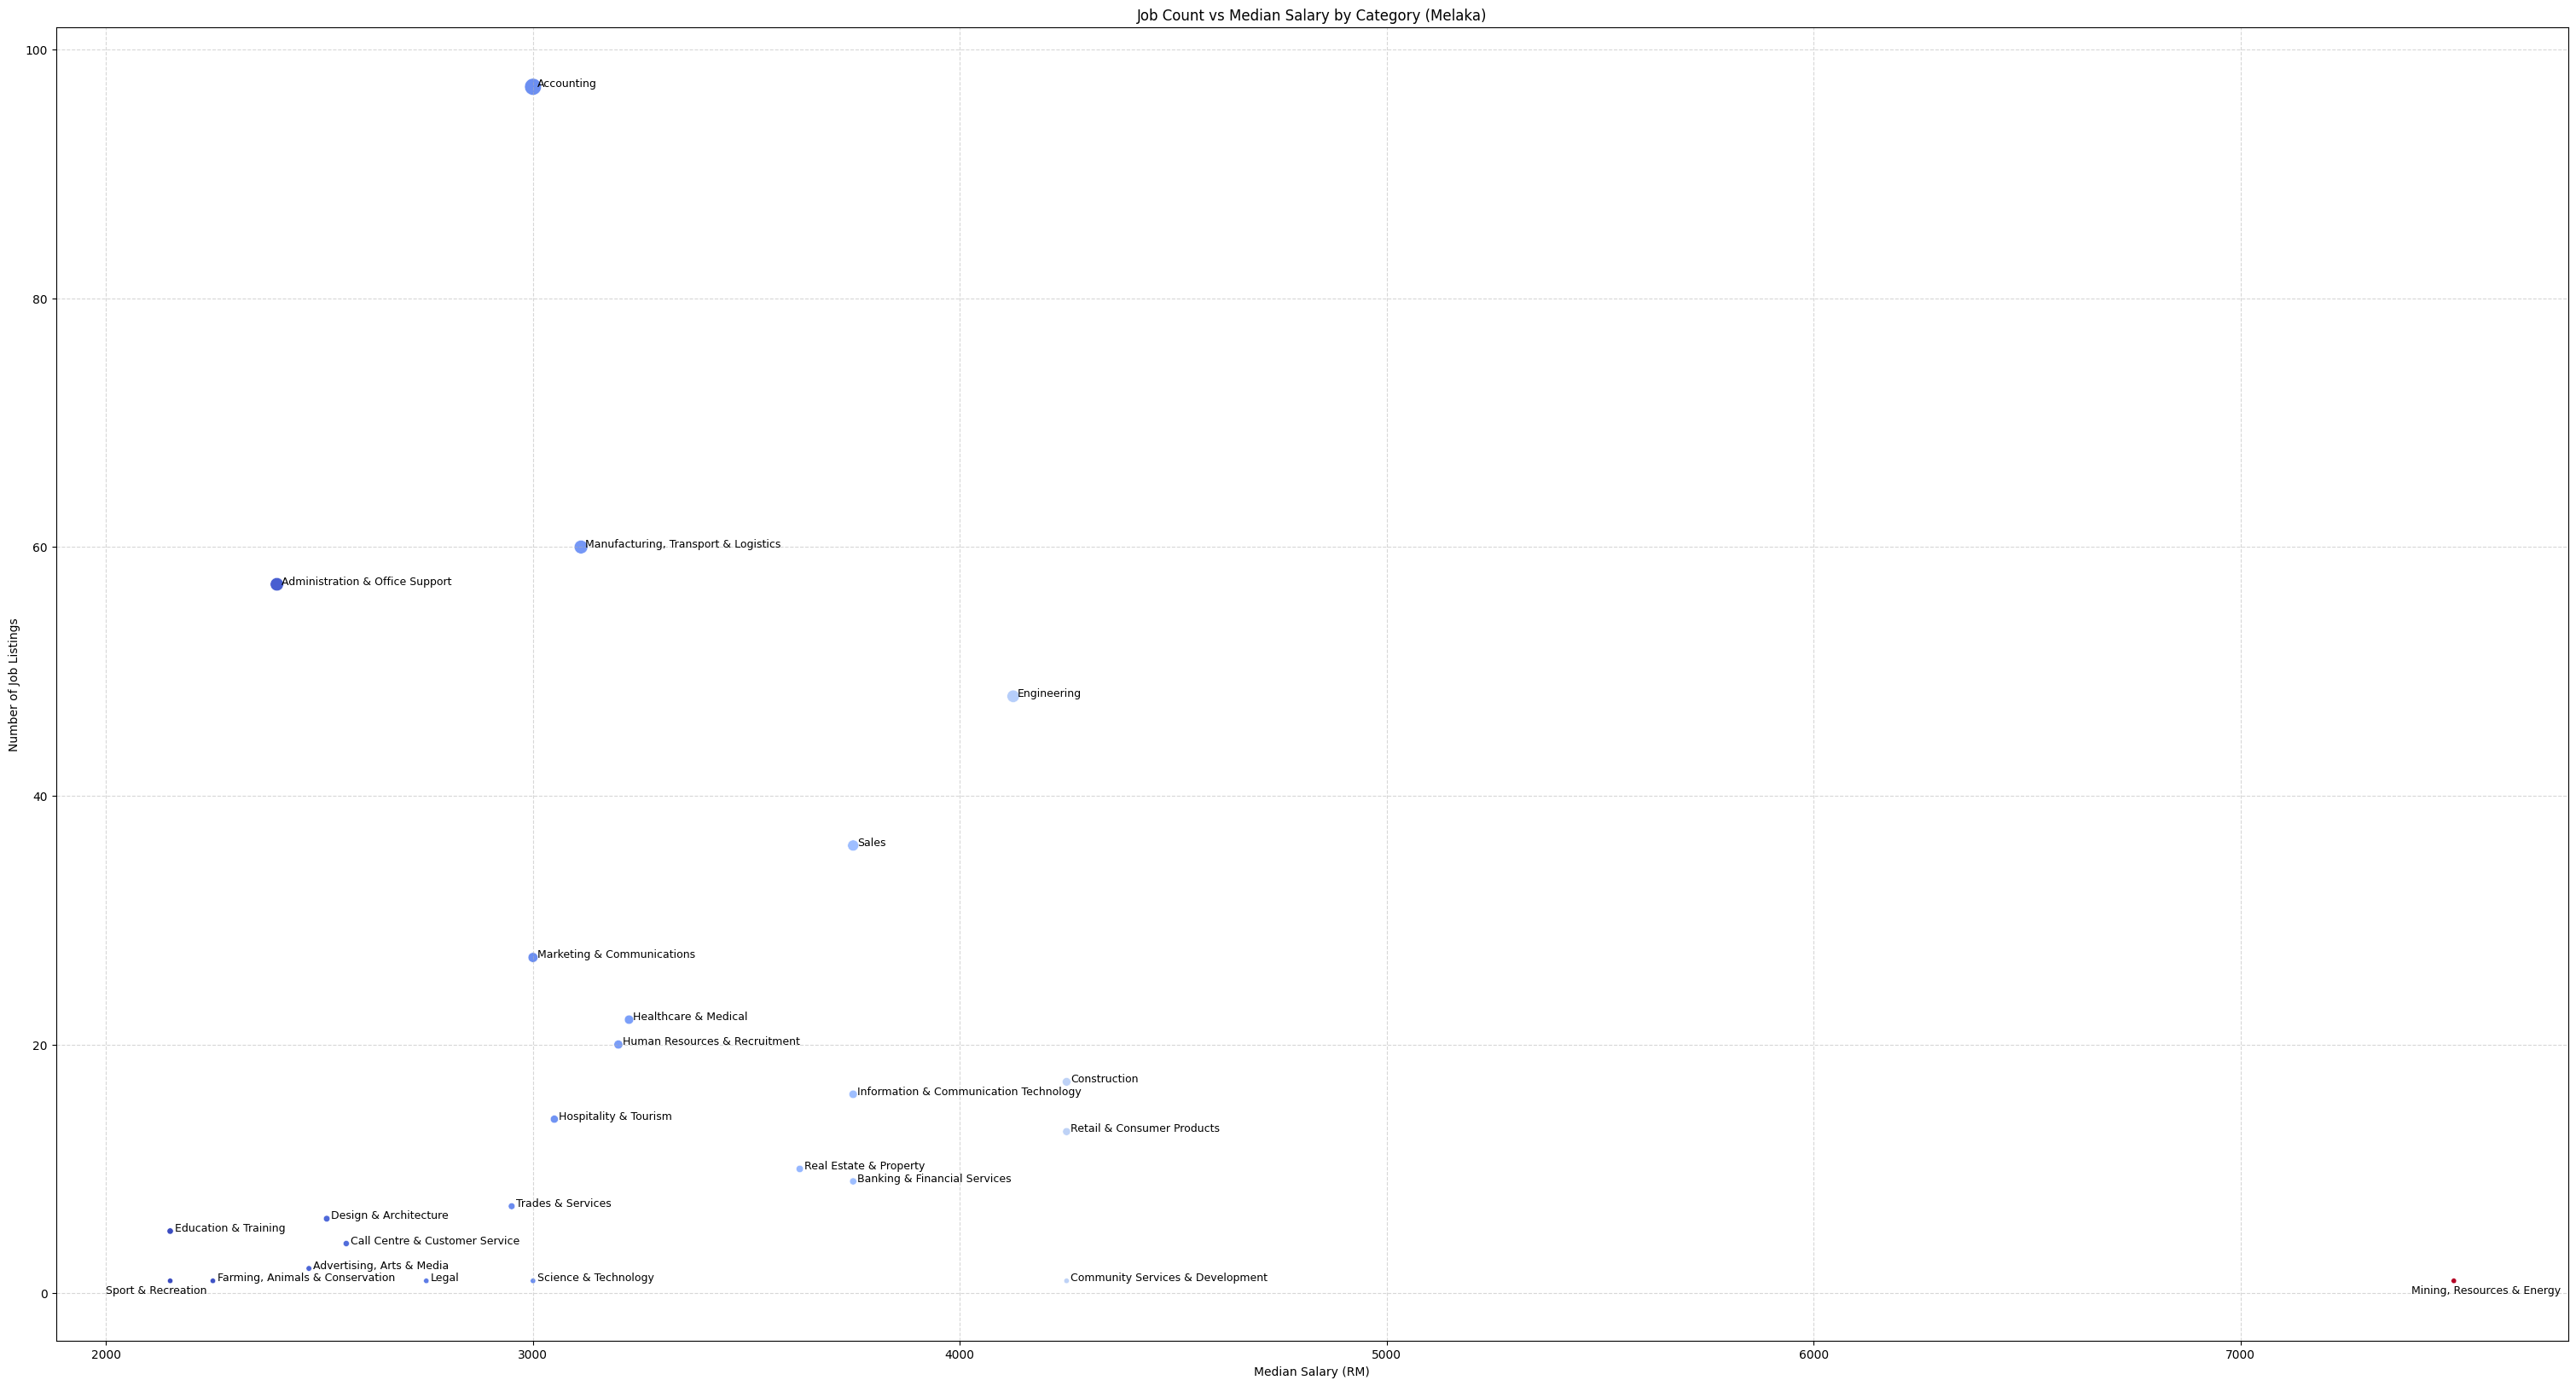

In [ ]:
# Scatter Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(38,20))
sns.scatterplot(data = data_merge, x = "Median_Salary", y = "count", size = "count" , hue = "Median_Salary" , palette = "coolwarm", sizes=(20,200) , legend=False)

for i in range(data_merge.shape[0]):
    x = data_merge["Median_Salary"].iloc[i]
    y = data_merge["count"].iloc[i]
    label = data_merge["category"].iloc[i]

    if label == "Sport & Recreation":
        x -= 150
        y -= 1
    elif label == "Mining, Resources & Energy":
        x -= 100
        y -= 1
    else:
        x += 10

    plt.text(x, y, label, horizontalalignment='left', size=9)

plt.title('Job Count vs Median Salary by Category (Melaka)')
plt.xlabel('Median Salary (RM)')
plt.ylabel('Number of Job Listings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("job_count_vs_salary.png")
plt.show()

# Interpretation & Conclusion

## Region Table

| Region           | X (Salary)  | Y (Count)  | Interpretation                                                                                              |
| ---------------- | ----------- | ---------- | ----------------------------------------------------------------------------------------------------------- |
| **Top-left**     | Low salary  | High count | Many jobs available but pay is low (Accounting, Admin and Manufacturing). Good for volume but not high-paying roles (RM2500-RM3500)    |
| **Top-right**    | High salary | High count | Rare in most regions. If it exists, it’s high-demand, high-pay sector. Usually limited or specialized jobs. |
| **Bottom-left**  | Low salary  | Low count  | Rare, low-paying jobs. Low opportunity and low pay.                                     |
| **Bottom-right** | High salary | Low count  | Highly specialized, high-paying jobs (Mining, Engineering, Construction). Few positions, competitive. |


## Interpretation

- In the top left it can be seen that Accounting, Admin and Manufacturing is have the high job availability and easy to hired but lower median salary.
- The middle region, which have the moderate salary and moderate job count is in the Healthcare, Human Resources, Marketing and Information Technology
- This chart can be use by job seeker to identify which job category have the high demand and high salary

## Conclusion

As the conclusion, the job market in Melaka shows that Accounting, Administation, and Manufacturing are the top categories with the highest job vacancies. These sector may become the priority choice for fresh gradute when they seeking for job opportunity in Melaka. Meanwhile, there are also several job categories which have offer slightly higher salary but have fewer opportunity such as Engineering, Information Technology and Sales. Overall, fresh graduate can consider targeting high demand sectors first such as Accounting when they seek for job in Melaka.